<a href="https://colab.research.google.com/github/music-data-mining/W08/blob/master/Week08_Keras_DNN_Implementations_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 08 Keras DNN Implementations Lab

Reference: Textbook Chapter 10 & 11

##Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Building an Image Classifier

First let's import TensorFlow and Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
#Loading the dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
# splitting the full training set into a validation set and a (smaller) training set
# scaling the pixel intensities down to the 0-1 range
# and converting them to floats, by dividing by 255
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

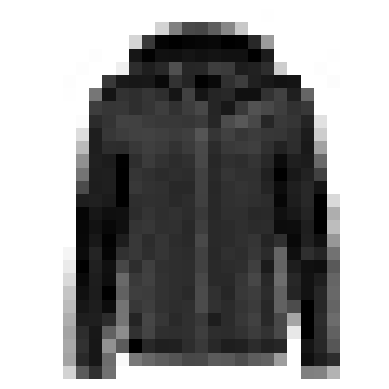

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train #array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

'Coat'

Let's take a look at a sample of the images in the dataset:

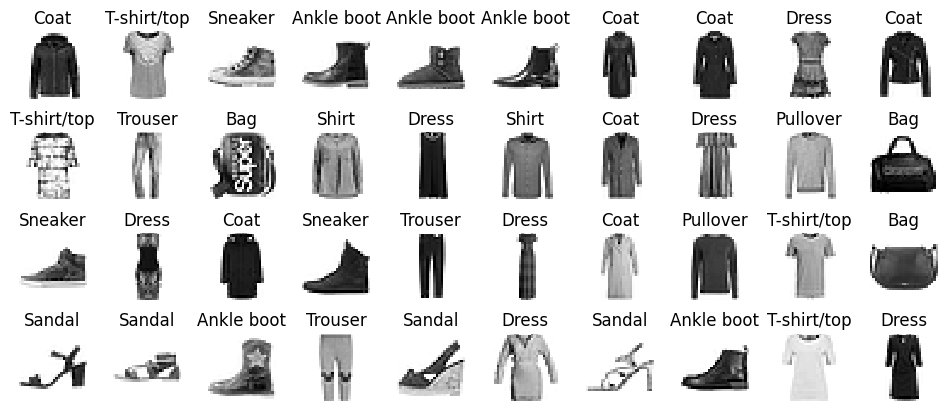

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Creaing the model using the Sequential API

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# option1: creat model by adding layers one by one
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
# option2: creat model as a whole
# the two options are equivalent
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 84060 (328.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compliling the model

In [ ]:
# to see what args can be tuned when compiling a model, checkout https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Training and evaluating the model

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 10s 3ms/step - loss: 0.7708 - accuracy: 0.7432 - val_loss: 0.5342 - val_accuracy: 0.8176
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5037 - accuracy: 0.8234 - val_loss: 0.4465 - val_accuracy: 0.8474
Epoch 3/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4569 - accuracy: 0.8390 - val_loss: 0.5201 - val_accuracy: 0.8032
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4306 - accuracy: 0.8498 - val_loss: 0.4075 - val_accuracy: 0.8608
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4128 - accuracy: 0.8547 - val_loss: 0.3907 - val_accuracy: 0.8634
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3945 - accuracy: 0.8614 - val_loss: 0.3837 - val_accuracy: 0.8690
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3827 - accuracy: 0.8637 - val_loss: 0.3798 - val_accurac

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


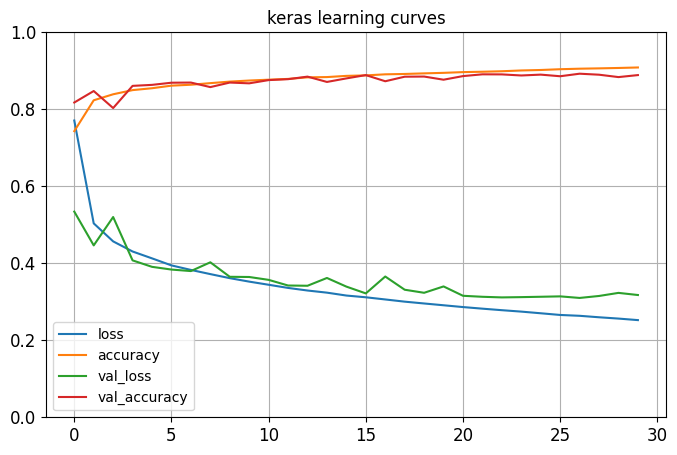

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()

In [ ]:
# measure how well the model perform on the test set
# test_loss and test_accuracy
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3504 - accuracy: 0.8781


[0.35038185119628906, 0.8780999779701233]

# Building the model 1
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 10\*20\*30\*50\*10
- Initialization: Norm

Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3051 - accuracy: 0.0991 - val_loss: 2.3043 - val_accuracy: 0.1008
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3038 - accuracy: 0.0982 - val_loss: 2.3037 - val_accuracy: 0.0976
Epoch 3/50
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3038 - accuracy: 0.0983 - val_loss: 2.3061 - val_accuracy: 0.0986
Epoch 4/50
1719/1719 [==============================] - 8s 5ms/step - loss: 2.3036 - accuracy: 0.1009 - val_loss: 2.3023 - val_accuracy: 0.0986
Epoch 5/50
1719/1719 [==============================] - 6s 3ms/step - loss: 2.3037 - accuracy: 0.0979 - val_loss: 2.3045 - val_accuracy: 0.0986
Epoch 6/50
1719/1719 [==============================] - 7s 4ms/step - loss: 2.3035 - accuracy: 0.0980 - val_loss: 2.3038 - val_accuracy: 0.0980
Epoch 7/50
1719/1719 [==============================] - 6s 4ms/step - loss: 2.3033 - accuracy: 0.1030 - val_loss: 2.3034 - val_accuracy:

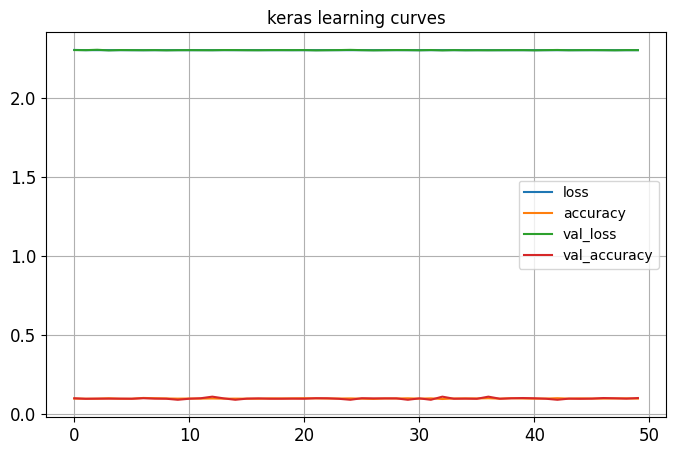

313/313 [==============================] - 1s 3ms/step - loss: 2.3032 - accuracy: 0.1000
[2.303159713745117, 0.10000000149011612]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(10, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(20, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(30, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 10760 (42.03 KB)
Trainable params: 10760 (

# Building the model 2
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Norm

Epoch 1/30
1719/1719 [==============================] - 12s 6ms/step - loss: 2.2235 - accuracy: 0.3236 - val_loss: 2.0721 - val_accuracy: 0.5010
Epoch 2/30
1719/1719 [==============================] - 10s 6ms/step - loss: 1.7542 - accuracy: 0.5123 - val_loss: 1.4543 - val_accuracy: 0.5898
Epoch 3/30
1719/1719 [==============================] - 6s 4ms/step - loss: 1.2943 - accuracy: 0.5955 - val_loss: 1.1556 - val_accuracy: 0.6390
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0729 - accuracy: 0.6367 - val_loss: 0.9895 - val_accuracy: 0.6570
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9383 - accuracy: 0.6801 - val_loss: 0.8794 - val_accuracy: 0.7182
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8403 - accuracy: 0.7135 - val_loss: 0.7946 - val_accuracy: 0.7340
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7678 - accuracy: 0.7289 - val_loss: 0.7315 - val_accurac

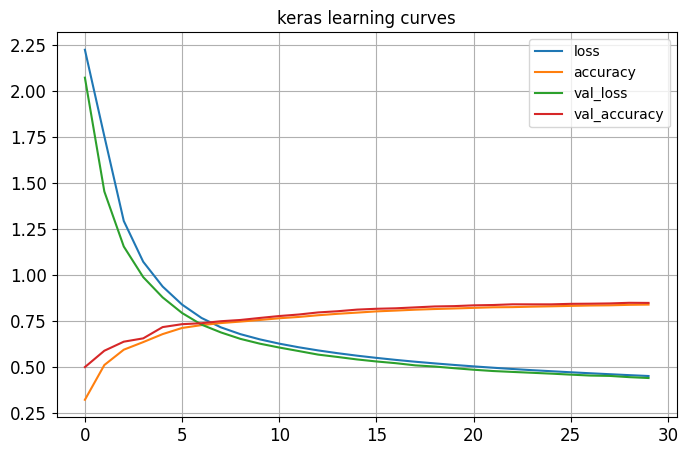

313/313 [==============================] - 1s 3ms/step - loss: 0.4830 - accuracy: 0.8272
[0.48297226428985596, 0.8271999955177307]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 84060 (328.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Building the model 3
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Norm

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5624 - accuracy: 0.7965 - val_loss: 0.4071 - val_accuracy: 0.8520
Epoch 2/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3987 - accuracy: 0.8543 - val_loss: 0.4036 - val_accuracy: 0.8558
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3619 - accuracy: 0.8667 - val_loss: 0.3402 - val_accuracy: 0.8752
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3361 - accuracy: 0.8764 - val_loss: 0.3239 - val_accuracy: 0.8810
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3194 - accuracy: 0.8821 - val_loss: 0.3221 - val_accuracy: 0.8828
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3052 - accuracy: 0.8884 - val_loss: 0.3361 - val_accuracy: 0.8802
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2948 - accuracy: 0.8903 - val_loss: 0.3140 - val_accuracy:

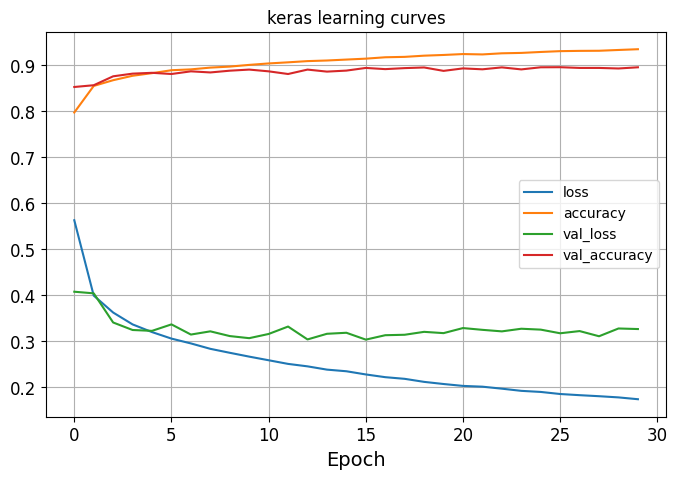

313/313 [==============================] - 1s 3ms/step - loss: 0.3710 - accuracy: 0.8850
[0.37104320526123047, 0.8849999904632568]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(50, activation="relu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.05)),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.xlabel('Epoch')
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 4
- Activation function: Sigmoid
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Xavier

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="sigmoid", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(50, activation="sigmoid", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 2.0624 - accuracy: 0.4478 - val_loss: 1.6905 - val_accuracy: 0.5592
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 1.4127 - accuracy: 0.6125 - val_loss: 1.1957 - val_accuracy: 0.6658
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0877 - accuracy: 0.6678 - val_loss: 0.9818 - val_accuracy: 0.6930
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9195 - accuracy: 0.6990 - val_loss: 0.8481 - val_accuracy: 0.7232
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8116 - accuracy: 0.7228 - val_loss: 0.7607 - val_accuracy: 0.7482
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7382 - accuracy: 0.7399 - val_loss: 0.6993 - val_accuracy: 0.7598
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6873 - accuracy: 0.7531 - val_loss: 0.6540 - val_accuracy:

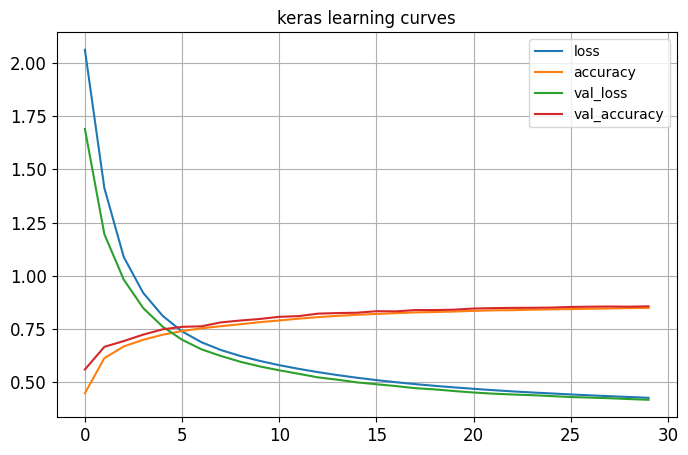

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4590 - accuracy: 0.8353


[0.45895177125930786, 0.8353000283241272]

# Building the model 5
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: Xavier

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7894 - accuracy: 0.7415 - val_loss: 0.5422 - val_accuracy: 0.8120
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5043 - accuracy: 0.8235 - val_loss: 0.4556 - val_accuracy: 0.8434
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4568 - accuracy: 0.8395 - val_loss: 0.5717 - val_accuracy: 0.7856
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4308 - accuracy: 0.8488 - val_loss: 0.4129 - val_accuracy: 0.8598
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4132 - accuracy: 0.8547 - val_loss: 0.3949 - val_accuracy: 0.8626
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3964 - accuracy: 0.8602 - val_loss: 0.3945 - val_accuracy: 0.8664
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3847 - accuracy: 0.8644 - val_loss: 0.3823 - val_accuracy:

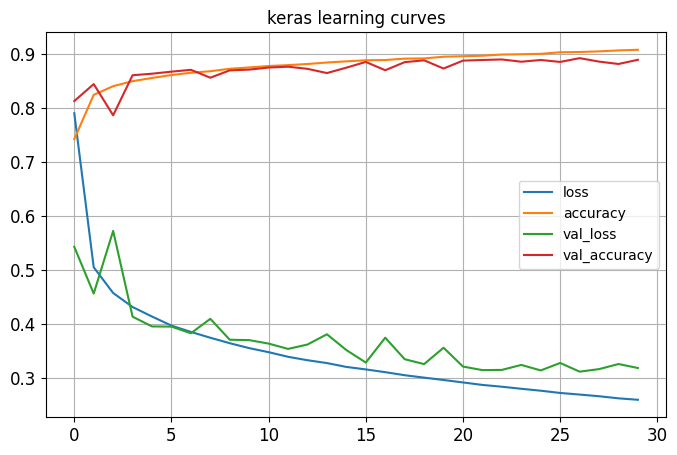

313/313 [==============================] - 1s 2ms/step - loss: 0.3515 - accuracy: 0.8768
[0.3515462279319763, 0.876800000667572]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='GlorotNormal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 6
- Activation function: ReLU
- Optimization: SGD
- Architecture: 100\*50\*10
- Initialization: he_normal

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7398 - accuracy: 0.7506 - val_loss: 0.5232 - val_accuracy: 0.8188
Epoch 2/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4946 - accuracy: 0.8253 - val_loss: 0.4470 - val_accuracy: 0.8500
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4497 - accuracy: 0.8421 - val_loss: 0.5378 - val_accuracy: 0.7970
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4242 - accuracy: 0.8505 - val_loss: 0.4121 - val_accuracy: 0.8568
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4064 - accuracy: 0.8566 - val_loss: 0.3954 - val_accuracy: 0.8620
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3874 - accuracy: 0.8631 - val_loss: 0.3823 - val_accuracy: 0.8680
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3758 - accuracy: 0.8681 - val_loss: 0.3815 - val_accuracy:

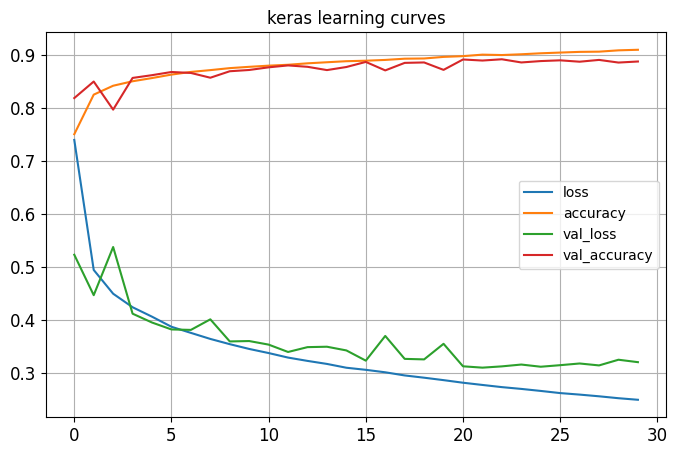

313/313 [==============================] - 1s 2ms/step - loss: 0.3563 - accuracy: 0.8748
[0.3562610447406769, 0.8748000264167786]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 7
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5389 - accuracy: 0.8057 - val_loss: 0.4007 - val_accuracy: 0.8566
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4013 - accuracy: 0.8531 - val_loss: 0.4059 - val_accuracy: 0.8556
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3628 - accuracy: 0.8664 - val_loss: 0.3574 - val_accuracy: 0.8710
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3373 - accuracy: 0.8755 - val_loss: 0.3194 - val_accuracy: 0.8838
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3216 - accuracy: 0.8806 - val_loss: 0.3293 - val_accuracy: 0.8798
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3067 - accuracy: 0.8857 - val_loss: 0.3387 - val_accuracy: 0.8742
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2991 - accuracy: 0.8903 - val_loss: 0.3077 - val_accuracy:

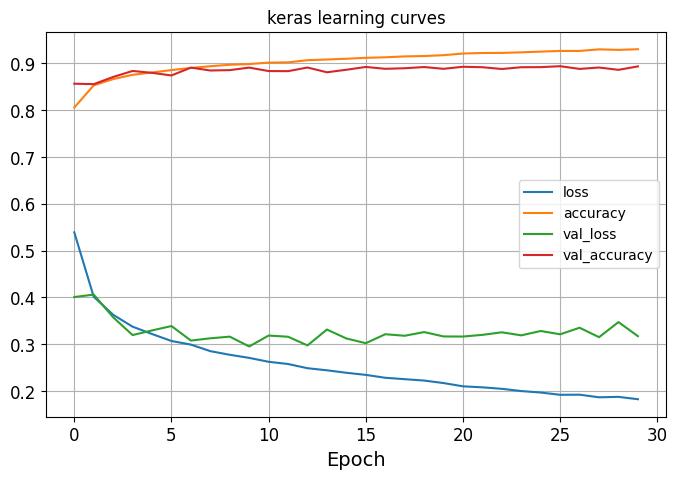

313/313 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.8893
[0.3521628677845001, 0.8892999887466431]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("keras learning curves")
plt.xlabel('Epoch')
plt.show()


print(model.evaluate(X_test, y_test))

# Building the model 8
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He
- Epoch: 100

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5399 - accuracy: 0.8061 - val_loss: 0.4270 - val_accuracy: 0.8452
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3951 - accuracy: 0.8553 - val_loss: 0.4141 - val_accuracy: 0.8532
Epoch 3/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3568 - accuracy: 0.8671 - val_loss: 0.3457 - val_accuracy: 0.8724
Epoch 4/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3334 - accuracy: 0.8770 - val_loss: 0.3224 - val_accuracy: 0.8824
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3171 - accuracy: 0.8825 - val_loss: 0.3197 - val_accuracy: 0.8808
Epoch 6/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3042 - accuracy: 0.8884 - val_loss: 0.3349 - val_accuracy: 0.8806
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2949 - accuracy: 0.8915 - val_loss: 0.3148 - val_ac

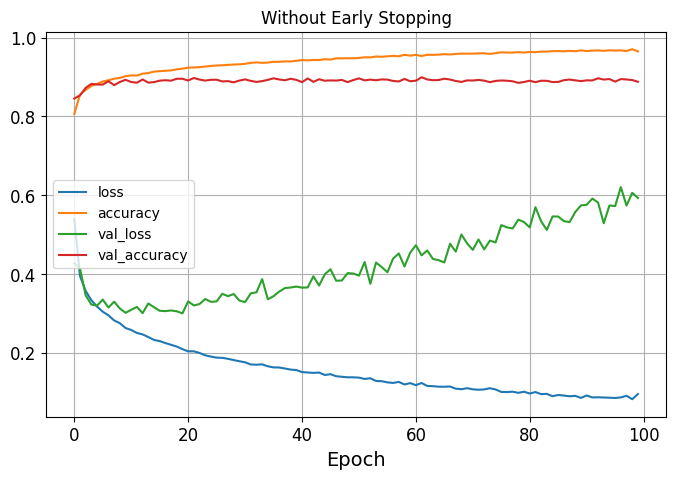

313/313 [==============================] - 1s 2ms/step - loss: 0.6422 - accuracy: 0.8816
[0.642236590385437, 0.881600022315979]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("Without Early Stopping")
plt.xlabel('Epoch')
plt.show()

print(model.evaluate(X_test, y_test))

# Building the model 9
- Activation function: ReLU
- Optimization: Mom
- Architecture: 100\*50\*10
- Initialization: He
- Early Stopping

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5407 - accuracy: 0.8055 - val_loss: 0.4108 - val_accuracy: 0.8536
Epoch 2/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3962 - accuracy: 0.8550 - val_loss: 0.4096 - val_accuracy: 0.8496
Epoch 3/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3620 - accuracy: 0.8662 - val_loss: 0.3512 - val_accuracy: 0.8738
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3341 - accuracy: 0.8759 - val_loss: 0.3236 - val_accuracy: 0.8792
Epoch 5/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3182 - accuracy: 0.8817 - val_loss: 0.3255 - val_accuracy: 0.8838
Epoch 6/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - accuracy: 0.8883 - val_loss: 0.3254 - val_accuracy: 0.8840
Epoch 7/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2922 - accuracy: 0.8920 - val_loss: 0.3125 - val_accuracy:

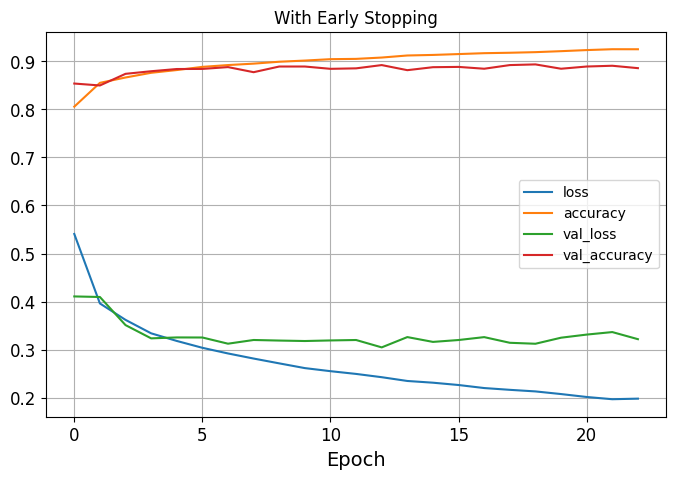

313/313 [==============================] - 1s 2ms/step - loss: 0.3593 - accuracy: 0.8772
[0.35934045910835266, 0.8772000074386597]


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title("With Early Stopping")
plt.xlabel('Epoch')
plt.show()

print(model.evaluate(X_test, y_test))

# Hyperparameter Tuning

In [ ]:
!pip install scikeras[tensorflow]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

from scikeras.wrappers import KerasClassifier

def create_model(units=10):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28]))
  model.add(keras.layers.Dense(100, activation="relu", kernel_initializer='he_normal'))
  model.add(keras.layers.Dense(units=units, activation="relu", kernel_initializer='he_normal'))
  model.add(keras.layers.Dense(10, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy",
              optimizer = 'adam',
              metrics=["accuracy"])
  return model

model = KerasClassifier(model=create_model, epochs=30, batch_size=10, verbose=0)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "epochs": [30, 50, 100, 150, 200]
}

grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_cv.fit(X_valid, y_valid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: ignored

In [ ]:
grid_cv.best_params_ #{'units': 150}